# Time Series Prediction with Van der Pol Oscillator Inspired Deep Learning ($VPINN$)

AUTHOR: Anurag Dutta (anuragdutta.research@gmail.com)

SUPERVISOR: Tanujit Chakraborty (tanujit.chakraborty@sorbonne.ae)

CREATED: 2023-03-07 19:36:04

## Gathering Dependencies

_Importing Required Libraries_

In [1]:
pip install hampel

You should consider upgrading via the 'C:\Users\Anurag Dutta\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip' command.


In [2]:
from keras.models import Sequential
from keras.layers import Dropout
from keras.layers import Dense
from keras.layers import LSTM
import keras
import tensorflow as tf
from hampel import hampel
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.callbacks import EarlyStopping

## Pretraining

_Van der Pol intermittancy_

The `van_der_pol_intermittency.dat` is generated from the Runge Kutta Method.

This feeds the model with the dynamics of the Van der Pol Oscillator

In [3]:
data = np.genfromtxt('datasets/van_der_pol_intermittency.dat')
training_set = pd.DataFrame(data).reset_index(drop=True)
training_set = training_set.iloc[:,1]

## Computing the Gradients

_Calculating the value of_ $\frac{dx}{dt}$, _and_ $\frac{d^2x}{dt^2}$

In [4]:
t_diff = 1 # Daily Data
print(training_set.max())
gradient_t = (training_set.diff()/t_diff).iloc[1:]
print(gradient_t)
gradient_tt = (gradient_t.diff()/t_diff).iloc[1:]
print(gradient_tt)

1.0
1        -0.000100
2        -0.000204
3        -0.000312
4        -0.000425
5        -0.000541
            ...   
139867    0.004633
139868    0.004629
139869    0.004624
139870    0.004619
139871    0.004614
Name: 1, Length: 139871, dtype: float64
2        -0.000104
3        -0.000108
4        -0.000112
5        -0.000117
6        -0.000121
            ...   
139867   -0.000005
139868   -0.000005
139869   -0.000005
139870   -0.000005
139871   -0.000005
Name: 1, Length: 139870, dtype: float64


## Loading Datasets

_TURKEY EARTHQUAKE_

In [5]:
data = pd.read_csv("datasets/eq.csv")
training_set = data.iloc[:, 4]
print(training_set)

0       4.4
1       5.2
2       4.8
3       4.4
4       5.7
       ... 
6569    4.5
6570    4.0
6571    4.4
6572    4.1
6573    4.0
Name: Magnitude, Length: 6574, dtype: float64


In [6]:
training_set = training_set.reset_index(drop=True)
gradient_t = gradient_t.reset_index(drop=True)
gradient_tt = gradient_tt.reset_index(drop=True)
print(gradient_t)
print(gradient_tt)

0        -0.000100
1        -0.000204
2        -0.000312
3        -0.000425
4        -0.000541
            ...   
139866    0.004633
139867    0.004629
139868    0.004624
139869    0.004619
139870    0.004614
Name: 1, Length: 139871, dtype: float64
0        -0.000104
1        -0.000108
2        -0.000112
3        -0.000117
4        -0.000121
            ...   
139865   -0.000005
139866   -0.000005
139867   -0.000005
139868   -0.000005
139869   -0.000005
Name: 1, Length: 139870, dtype: float64


In [7]:
print(gradient_t.shape)
print(training_set.shape[:-1])
df = pd.concat((training_set[:-1], gradient_t), axis=1)
gradient_tt.columns = ["grad_tt"]
df = pd.concat((df[:-1], gradient_tt), axis=1)
df.columns = ['y_t', 'grad_t', 'grad_tt']

(139871,)
()


## Plot of the External Forcing from Chaotic Differential Equation (_Van der Pol Oscillator_)

_Parameters_: $\mu=4\\$
$\frac{dx}{dt} = \mu(x-\frac{x^3}{3}-y)\\
\frac{dy}{dt} = \frac{x}{\mu}\\$


<AxesSubplot:>

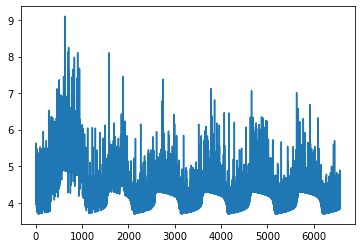

In [8]:
mu = 4
L = df.iloc[:, 2] - mu * (df.iloc[:, 1] - (df.iloc[:, 0]**2 * df.iloc[:, 1]) - (1/mu) * df.iloc[:, 0])
L.plot()

## Preprocessing the Data into Supervised Learning

In [9]:
def Supervised(data, n_in=1):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    cols.append(df)
    names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
    sup = pd.concat(cols, axis=1)
    sup.columns = names
    sup.dropna(inplace=True)
    return sup


data = Supervised(df.values, n_in=10)
data.drop(['var2(t-10)', 'var3(t-10)', 'var2(t-9)', 'var3(t-9)', 'var2(t-8)',
           'var3(t-8)', 'var2(t-7)', 'var3(t-7)', 'var2(t-6)', 'var3(t-6)',
           'var2(t-5)', 'var3(t-5)', 'var2(t-4)', 'var3(t-4)', 'var2(t-2)',
           'var3(t-2)', 'var2(t-1)', 'var3(t-1)', 'var2(t-3)', 'var3(t-3)'], axis=1, inplace=True)
print(data.head())
print(data.columns)
scaler = MinMaxScaler(feature_range=(0, 1))
data = scaler.fit_transform(data)
print(data.shape)
y = data[:, -3:]
x = data[:, :-3]
print(x.shape)


    var1(t-10)  var1(t-9)  var1(t-8)  var1(t-7)  var1(t-6)  var1(t-5)  \
10         4.4        5.2        4.8        4.4        5.7        4.3   
11         5.2        4.8        4.4        5.7        4.3        4.0   
12         4.8        4.4        5.7        4.3        4.0        4.8   
13         4.4        5.7        4.3        4.0        4.8        5.2   
14         5.7        4.3        4.0        4.8        5.2        5.1   

    var1(t-4)  var1(t-3)  var1(t-2)  var1(t-1)  var1(t)   var2(t)   var3(t)  
10        4.0        4.8        5.2        5.1      4.7 -0.001336 -0.000148  
11        4.8        5.2        5.1        4.7      4.6 -0.001484 -0.000152  
12        5.2        5.1        4.7        4.6      4.4 -0.001635 -0.000155  
13        5.1        4.7        4.6        4.4      4.7 -0.001791 -0.000158  
14        4.7        4.6        4.4        4.7      4.1 -0.001949 -0.000161  
Index(['var1(t-10)', 'var1(t-9)', 'var1(t-8)', 'var1(t-7)', 'var1(t-6)',
       'var1(t-5)', 

## Train and Test Split

In [10]:
train_size = int(len(y) * 0.8)
test_size = len(y) - train_size
dataX = np.array(x)
dataY = np.array(y)
trainX = np.array(x[0:train_size])
trainY = np.array(y[0:train_size])
testX = np.array(x[train_size:len(x)])
testY = np.array(y[train_size:len(y)])
trainX = trainX.reshape((trainX.shape[0], 1, trainX.shape[1]))
testX = testX.reshape((testX.shape[0], 1, testX.shape[1]))
print(trainX.shape, trainY.shape, testX.shape, testY.shape)

(5250, 1, 10) (5250, 3) (1313, 1, 10) (1313, 3)


## Defining the Physical Loss

In [11]:
mu = tf.Variable(4, name="mu", trainable=True, dtype=tf.float32)


def phys(y_pred, y_true):
    return mean_absolute_error(y_true[:, 2] - mu * (y_true[:, 1] - (y_true[:, 0]**2 * y_true[:, 1]) - (1/mu) * y_true[:, 0]), y_pred[:, 2] - mu * (y_pred[:, 1] - (y_pred[:, 0]**2 * y_pred[:, 1]) - (1/mu) * y_pred[:, 0]))


def phys2(y_pred, y_real):
    pred = y_pred[2:]-2*y_pred[1:-1]-y_pred[:-2] - mu * ((y_pred[1:-1]-y_pred[:-2]) - (y_pred[:-2]**2 * (y_pred[1:-1]-y_pred[:-2])) - (1/mu) * y_pred[:-2])
    real = y_real[2:]-2*y_real[1:-1]-y_real[:-2] - mu * ((y_real[1:-1]-y_real[:-2]) - (y_real[:-2]**2 * (y_real[1:-1]-y_real[:-2])) - (1/mu) * y_real[:-2])
    return(mean_absolute_error(pred, real))

## Model ($VPINN$)

In [12]:
mu = tf.Variable(4, name="mu", trainable=True, dtype=tf.float32)

def loss_fn(y_true, y_pred):
    squared_difference = tf.square(y_true[:, 0] - y_pred[:, 0])
    squared_difference2 = tf.square(y_true[:, 2]-y_pred[:, 2])
    squared_difference1 = tf.square(y_true[:, 1]-y_pred[:, 1])
    squared_difference3 = tf.square(
        y_pred[:, 2] - mu * (y_pred[:, 1] - (y_pred[:, 0]**2 * y_pred[:, 1]) - (1/mu) * y_pred[:, 0]))
    return tf.reduce_mean(squared_difference, axis=-1) + 0.2*tf.reduce_mean(squared_difference3, axis=-1)

model = Sequential()
model.add(LSTM(50, input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(Dense(3))
model.compile(loss=loss_fn, optimizer='adam')
history = model.fit(trainX, trainY, epochs=500, batch_size=64,
                    validation_data=(testX, testY), verbose=2, shuffle=False)

Epoch 1/500
83/83 - 11s - loss: 0.0174 - val_loss: 0.0087 - 11s/epoch - 137ms/step
Epoch 2/500
83/83 - 1s - loss: 0.0134 - val_loss: 0.0087 - 854ms/epoch - 10ms/step
Epoch 3/500
83/83 - 1s - loss: 0.0131 - val_loss: 0.0086 - 925ms/epoch - 11ms/step
Epoch 4/500
83/83 - 1s - loss: 0.0129 - val_loss: 0.0086 - 954ms/epoch - 11ms/step
Epoch 5/500
83/83 - 1s - loss: 0.0129 - val_loss: 0.0086 - 1s/epoch - 12ms/step
Epoch 6/500
83/83 - 1s - loss: 0.0129 - val_loss: 0.0086 - 749ms/epoch - 9ms/step
Epoch 7/500
83/83 - 1s - loss: 0.0129 - val_loss: 0.0086 - 742ms/epoch - 9ms/step
Epoch 8/500
83/83 - 1s - loss: 0.0129 - val_loss: 0.0086 - 716ms/epoch - 9ms/step
Epoch 9/500
83/83 - 1s - loss: 0.0129 - val_loss: 0.0086 - 679ms/epoch - 8ms/step
Epoch 10/500
83/83 - 1s - loss: 0.0129 - val_loss: 0.0086 - 724ms/epoch - 9ms/step
Epoch 11/500
83/83 - 1s - loss: 0.0129 - val_loss: 0.0086 - 704ms/epoch - 8ms/step
Epoch 12/500
83/83 - 1s - loss: 0.0129 - val_loss: 0.0086 - 759ms/epoch - 9ms/step
Epoch 13/50

## Metrics ($VPINN$)

In [13]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
yhat = model.predict(testX)
print(yhat.shape)
testX = testX.reshape((testX.shape[0], testX.shape[2]))
print(testX.shape)
inv_yhat = np.concatenate((testX, yhat), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat1 = inv_yhat[:, -3:]
inv_yhat = inv_yhat[:, -3]
inv_y = np.concatenate((testX, testY), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y1 = inv_y[:, -3:]
inv_y = inv_y[:, -3]
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
mae = mean_absolute_error(inv_y, inv_yhat)
phy = phys2(inv_y, inv_yhat)
print('Test RMSE: %.3f' % rmse)
print('Test MAE: %.3f' % mae)

42/42 [==============================] - 3s 4ms/step
(1313, 3)
(1313, 10)
Test RMSE: 0.359
Test MAE: 0.255


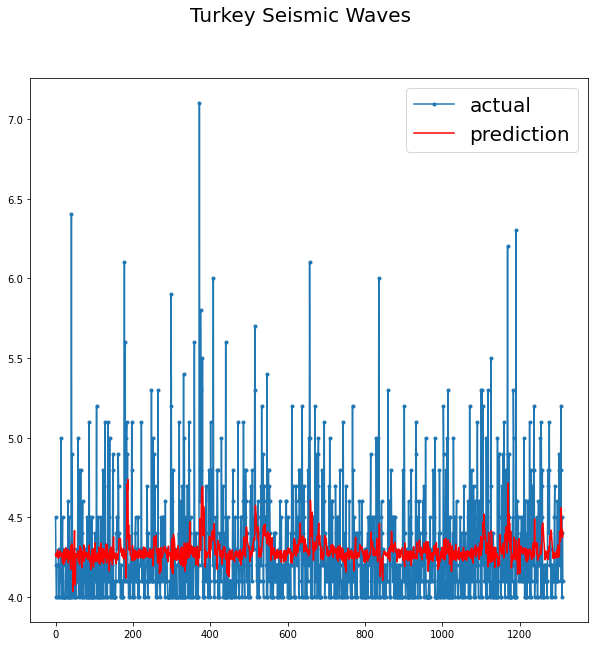

In [14]:
import matplotlib
matplotlib.rcParams['figure.figsize'] = [10, 10] # for square canvas
plt.plot(inv_y, marker='.', label="actual")
plt.plot(inv_yhat, 'r', label="prediction")
plt.suptitle('Turkey Seismic Waves', fontsize=20)
plt.legend(fontsize=20)
plt.show()